# Regra de Taylor

Primeira equação:

\begin{align}
i_t = \alpha_0 + \alpha_1 (\pi_{t} - \pi_{t}^{M}) + \alpha_2 h_{t-1}  + \epsilon_t
\end{align}

Em que $i_t$ representa a meta da taxa de juros nominal, $\pi_{t} - \pi_{t}^{M}$ os desvios da inflação em relação a meta, $h_t$ o hiato do produto (diferença entre o produto real e produto potencial), por fim, temos $\epsilon_t$ representando os choques. Aqui a constante $\alpha_0$ representa o taxa de juro neutra invariante no tempo.

A segunda equação estabelece mais estrutura para a regra:

$$i_t=\theta_1 i_{t-1}+\theta_2 i_{t-2}+\left(1-\theta_1-\theta_2\right) *\left[r_t^{e q}+\pi_t^{\text {meta }}+\theta_3\left(\pi_{t}-\pi_t^{\text {meta }}\right)\right]+\epsilon_t^i$$

Em que $r_t^{e q}$ representa a taxa de juros real neutra variante no tempo. $theta_1$ e $theta_2$ referem-se a coeficientes que visam ser uma suavizacao para o tempo de resposta da diretoria do banco central, bem como prevenir autocorrelação nos resíduos. Importante dizer que para garantir a convergencia desses termos autoregressivos é necessário que a soma dos termos seja inferior a 1.

Os dados utilizados referem-se:

- Taxa de juros - Meta Selic definida pelo Copom - Freq. diária - Unid. % a.a.

-	Índice nacional de preços ao consumidor-amplo (IPCA) Var. % mensal

- Meta para a inflação - CMN - Freq. anual - %

- Hiato do Produto criado pelo BCB, obtido pelo Relatório de Inflação.

- Juro Neutro: Expectativa da taxa Selic ao longo de uma horizonte de quatro anos à frente, desinflacionada pela expectativa de variação do IPCA para o mesmo período, ambas obtidas pela pesquisa Focus. Do resultado, aplica-se o Filtro HP para suavizar a série.

O coeficientes são estimados via OLS. Os dados que não se referem a frequência trimestral são transformados para a utilização do modelo.



## 1. Carregamento das bibliotecas

In [1]:
!pip install python-bcb

In [110]:
from bcb import sgs
from bcb import Expectativas
import pandas as pd
import numpy as np
from functools import reduce
import statsmodels.api as sm
from plotnine import *
import matplotlib.pyplot as plt

## 2.  Coleta e Tratamento de dados

### 2.1 Selic

Abaixo, começamos importando a taxa básica de juros que é calibrada pelo Banco Central.

In [4]:
# Taxa de juros - Meta Selic definida pelo Copom - Freq. diária - Unid. % a.a.
selic = sgs.get({'selic' : "432"}, start = "1999-01-01")

Selic Mensal

In [5]:
selic

,selic
Date,
1999-03-05,45.0
1999-03-06,45.0
1999-03-07,45.0
1999-03-08,45.0
1999-03-09,45.0
...,...
2024-05-11,10.5
2024-05-12,10.5
2024-05-13,10.5


Trimestralizando a Selic

In [26]:
# Trimestraliza a série
selic_t = (
    selic
    .resample('Q') # resample da data para trimestral
    .last() # captura o último valor do trimestre
    .reset_index()
    .assign(date_quarter = lambda x : pd.PeriodIndex(x.Date, freq = 'Q'))
    .drop('Date', axis = 1)
  )

In [27]:
selic_t

,selic,date_quarter
0,42.00,1999Q1
1,21.00,1999Q2
2,19.00,1999Q3
3,19.00,1999Q4
4,18.50,2000Q1
...,...,...
97,13.75,2023Q2
98,12.75,2023Q3
99,11.75,2023Q4
100,10.75,2024Q1


### 2.2 Meta de Inflação

In [8]:
# Meta para a inflação - CMN - Freq. anual - %
meta = sgs.get({'meta' : "13521"}, start = "1999-01-01")

Meta Inflação Anualizada

In [9]:
meta

,meta
Date,
1999-01-01,8.00
2000-01-01,6.00
2001-01-01,4.00
2002-01-01,3.50
2003-01-01,4.00
2004-01-01,5.50
2005-01-01,4.50
2006-01-01,4.50
2007-01-01,4.50


In [28]:
# Trimestraliza a série
meta_t = (
    meta
    .loc[np.repeat(meta.index.values, 4)]
    .reset_index()
    .assign(date_quarter =  lambda x: pd.date_range(start = x['Date'].iloc[0],
                   periods = len(x),
                   freq = 'Q').to_period('Q')
    )
    .loc[:, ['date_quarter', 'meta']]
  )

meta_t

,date_quarter,meta
0,1999Q1,8.00
1,1999Q2,8.00
2,1999Q3,8.00
3,1999Q4,8.00
4,2000Q1,6.00
...,...,...
99,2023Q4,3.25
100,2024Q1,3.00
101,2024Q2,3.00
102,2024Q3,3.00


In [29]:
# Expandindo amostra com dados de meta futura de inflação
new_rows = pd.DataFrame({
    'date_quarter': pd.date_range(start = '2022-01-01', periods = 24, freq = 'Q').to_period('Q'),
    'meta': np.repeat([3.5, 3.25, 3, 3, 3, 3], 4)
  })

# Junta as metas
meta_inflacao = pd.concat([meta_t, new_rows]).drop_duplicates(subset = "date_quarter")

### 2.3 Hiato do Produto

In [30]:
# Coleta e tratamento do Hiato do Produto do BC
hiato = (
    pd.read_excel(
    "https://www.bcb.gov.br/content/ri/relatorioinflacao/202403/ri202403anp.xlsx",
    sheet_name = "Graf 2.2.4",
    skiprows = 8
    )
    .assign(date_quarter = lambda x: pd.PeriodIndex(x['Trimestre'], freq = 'Q'),
            hiato = lambda x: x.Hiato.astype(float))
    .loc[:, ['date_quarter', 'hiato']]
    .dropna()
  )

In [31]:
hiato

,date_quarter,hiato
1,2003Q4,-0.83
2,2004Q1,-0.40
3,2004Q2,-0.03
4,2004Q3,0.35
5,2004Q4,0.63
...,...,...
78,2023Q1,-0.61
79,2023Q2,-0.64
80,2023Q3,-0.66
81,2023Q4,-0.60


### 2.4 Inflação


In [32]:
# Função para acumular os trimestres
def acum_quarter(x):
    """
    Acumula a variação percentual mensal em um trimestre.

    Argumentos:
    - x: lista, array ou série pandas contendo os valores de inflação.

    Retorno:
    - A inflação acumulada em um trimestre, em porcentagem.
    """

    # Transforma os valores em fatores de crescimento
    x_fac = 1 + (x / 100)

    # Calcula o produto acumulado dos últimos três valores
    x_cum = np.prod(x_fac[-3:])

    # Calcula o valor acumulado em um trimestre
    x_qr = (x_cum - 1) * 100

    return x_qr

In [33]:
# Função para anualizar os valores trimestrais
def acum_p(data, n):
    """
    Calcula a acumulação de variações percentuais em janelas móveis.

    Argumentos:
    - data: array-like
        Uma sequência de dados representando variações percentuais.

    - n: int
        O tamanho da janela móvel para o cálculo da acumulação.

    Retorno:
    - array
        Um array contendo a acumulação das variações percentuais em janelas móveis.
    """

    resultado = (((data / 100) + 1)
                 .rolling(window=n)
                 .apply(np.prod)
                 - 1) * 100
    return resultado

In [34]:
# Coleta dados do ipca mensal
ipca = sgs.get({'ipca' : 433}, start = '1999-01-01')

ipca_12m = (
    ipca
    .reset_index()
    # cria colunas de trimestre
    .assign(date_quarter = lambda x: pd.PeriodIndex(x['Date'], freq = 'Q'))
    # agrupa por trimestre e acumula os valores percentuais do período
    .groupby(by = 'date_quarter')
    .agg({
        'ipca': lambda x: acum_quarter(x)
    })
    .reset_index()
    # calcula o produto móvel de 4 trimestres
    .assign(ipca_12m = lambda x: acum_p(x.ipca, n = 4))
    .drop('ipca', axis = 1)
    )

ipca_12m

,date_quarter,ipca_12m
0,1999Q1,NaN
1,1999Q2,NaN
2,1999Q3,NaN
3,1999Q4,8.939935
4,2000Q1,6.923482
...,...,...
97,2023Q2,3.161501
98,2023Q3,5.185235
99,2023Q4,4.621114
100,2024Q1,3.925596


### 2.5 Juro Neutro

In [35]:
# Cria uma função para a equação de fisher
def fisher(juros, inflacao):
    """
    Calcula a taxa de juros real neutra usando a equação de Fisher.

    Args:
        juros (float): A taxa de juros nominal em porcentagem (%).
        inflacao (float): A taxa de inflação em porcentagem (%).

    Returns:
        float: A taxa de juros real em porcentagem (%).

    Raises:
        TypeError: Se os argumentos `juros` e `inflacao` não forem do tipo `float`.

    Exemplo:
        >>> fisher(10, 3)
        6.796116504854364
    """
    juros = ((((1 + (juros / 100)) / (1 + inflacao / 100))) -1) * 100
    return juros

# Cria função para calcular a data de referência a partir da data de observação
def reference_date(date: str, n):
    """
    Calcula a data de referência adicionando 3 anos a uma data de observação.

    Args:
        date (str): Uma string que representa uma data no formato 'YYYY-MM-DD'.

    Returns:
        List[str]: Uma lista de strings com a data de referência no formato 'YYYY'.

    Raises:
        TypeError: Se o argumento `date` não for uma string.

    Examples:
        >>> reference_date('2022-01-01', n = 3)
        ['2025']
    """
    years = pd.DatetimeIndex(date).year.values + n # Calcula n anos a frente
    years = years.tolist()
    years = [str(i) for i in years]
    return years

#### Expectativa do IPCA

In [36]:
# instância a classe de Expectativas
em = Expectativas()

# Conecta com a API das Expectativas de Mercado Anuais
exp_anual = em.get_endpoint('ExpectativasMercadoAnuais')

# Importa as expectativas do IPCA anuais e realiza os filtros
ipca_e_raw = (
  exp_anual.query()
  .filter(exp_anual.Indicador == "IPCA")
  .filter(exp_anual.baseCalculo == 0)
  .select(exp_anual.Data, exp_anual.Mediana, exp_anual.DataReferencia)
  .collect()
  )

# Realiza o filtro para a data de referência 4 anos a frente das obs.
ipca_e_t4 = ipca_e_raw[(
            ipca_e_raw
            .DataReferencia == reference_date(ipca_e_raw['Data'], n = 4)
            )]


# Renomeia as colunas e mensaliza
ipca_e_t4 = (
              ipca_e_t4.rename(columns =
                                        {'Data' : 'date',
                                        'Mediana' : 'ipca_e_t4'})
              .drop(['DataReferencia'], axis = 1)
              .assign(date = lambda x: pd.PeriodIndex(x['date'], freq = 'M'))
              .loc[:, ['date', 'ipca_e_t4']]
              .groupby(by = 'date')
              .agg(ipca_e_t4 = ('ipca_e_t4', 'mean'))
              .reset_index()
              .assign(date = lambda x : x.date.dt.to_timestamp())
            )


#### Expectativa da SELIC

In [37]:
# Importa as expectativas da Selic anuais e realiza os filtros
selic_e_raw = (
   exp_anual.query()
  .filter(exp_anual.Indicador == "Selic")
  .filter(exp_anual.baseCalculo == 0)
  .select(exp_anual.Data, exp_anual.Mediana, exp_anual.DataReferencia)
  .collect()
  )

# Realiza o filtro para a data de referência 4 anos a frente das obs.
selic_e_t4 = selic_e_raw[(
                        selic_e_raw
                        .DataReferencia == reference_date(selic_e_raw['Data'], n = 4)
                        )]

# Renomeia as colunas
selic_e_t4 = (
              selic_e_t4.rename(columns =
                                        {'Data' : 'date',
                                        'Mediana' : 'selic_e_t4'})
              .drop(['DataReferencia'], axis = 1)
              .assign(date = lambda x: pd.PeriodIndex(x['date'], freq = 'M'))
              .loc[:, ['date', 'selic_e_t4']]
              .groupby(by = 'date')
              .agg(selic_e_t4 = ('selic_e_t4', 'mean'))
              .reset_index()
              .assign(date = lambda x : x.date.dt.to_timestamp())
            )

#### Proxy Neutro T4

Temos então a medida $R_{t}^{n|focus4} = R_{t}^{focus4}$ abaixo

In [38]:
# Junta os dados em um data frame
proxy_neutro_t4 = (
                pd.merge(left = ipca_e_t4,
                        right = selic_e_t4,
                        how = 'inner',
                        on = 'date')
                .assign(neutro_t4 = lambda x : fisher(x.selic_e_t4, x.ipca_e_t4))
                )

# Trimestraliza o juro neutro
proxy_neutro_t4 = (
    proxy_neutro_t4
    .assign(date_quarter = lambda x: pd.PeriodIndex(x['date'], freq = 'Q'))
    .loc[:, ['date_quarter', 'neutro_t4']]
    .groupby(by = 'date_quarter')
    .agg(neutro = ('neutro_t4', 'mean'))
)

# Calcula o filtro HP
filtro_hp = sm.tsa.filters.hpfilter(x = proxy_neutro_t4['neutro'], lamb = 1600)

# Salva a tendência calculada
proxy_neutro_hp = pd.DataFrame(filtro_hp[1]).reset_index() # posição 1 é a tendência (0=ciclo);

### 2.5 Reunir os dados

In [39]:
# lista de dataframes
dados_regs = [selic_t, meta_inflacao, hiato, ipca_12m, proxy_neutro_hp]

# reduz os dataframes pela chave 'date_quarter' com left join
dados_reg = reduce(lambda left, right: pd.merge(left, right, on = 'date_quarter', how = 'outer'), dados_regs)

In [40]:
dados_reg

,selic,date_quarter,meta,hiato,ipca_12m,neutro_trend
0,42.0,1999Q1,8.0,NaN,NaN,NaN
1,21.0,1999Q2,8.0,NaN,NaN,NaN
2,19.0,1999Q3,8.0,NaN,NaN,NaN
3,19.0,1999Q4,8.0,NaN,8.939935,NaN
4,18.5,2000Q1,6.0,NaN,6.923482,NaN
...,...,...,...,...,...,...
111,NaN,2026Q4,3.0,NaN,NaN,NaN
112,NaN,2027Q1,3.0,NaN,NaN,NaN
113,NaN,2027Q2,3.0,NaN,NaN,NaN
114,NaN,2027Q3,3.0,NaN,NaN,NaN


### 2.5 Cria defasagens

In [41]:
# cria as colunas com os lags
## Defasagens da Selic
dados_reg['selic_lag1'] = dados_reg['selic'].shift(1)
dados_reg['selic_lag2'] = dados_reg['selic'].shift(2)
dados_reg['selic_lag3'] = dados_reg['selic'].shift(3)
dados_reg['selic_lag4'] = dados_reg['selic'].shift(4)
# Desvio da Meta (IPCA)
dados_reg['desvio_ipca'] = dados_reg['ipca_12m'] - dados_reg['meta']
# Defasagem do Hiato
dados_reg['hiato_lag1'] = dados_reg['hiato'].shift(1)

In [42]:
# Remove as linhas com valores ausentes
dados_reg_na = dados_reg.dropna()

# Transforma data em datetime
dados_reg_na.loc[:,'date_quarter'] = dados_reg_na['date_quarter'].dt.to_timestamp(freq = 'Q')

# Coloca a data no índice
dados_reg_na = dados_reg_na.set_index('date_quarter')

C:\Users\pedro\AppData\Local\Temp\ipykernel_26316\55337263.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [43]:
dados_reg_na

,selic,meta,hiato,ipca_12m,neutro_trend,selic_lag1,selic_lag2,selic_lag3,selic_lag4,desvio_ipca,hiato_lag1
date_quarter,,,,,,,,,,,
2004-03-31,16.25,5.50,-0.40,5.888224,7.363470,16.50,20.00,26.00,26.50,0.388224,-0.83
2004-06-30,16.00,5.50,-0.03,6.060064,7.261193,16.25,16.50,20.00,26.00,0.560064,-0.40
2004-09-30,16.25,5.50,0.35,6.705565,7.156467,16.00,16.25,16.50,20.00,1.205565,-0.03
2004-12-31,17.75,5.50,0.63,7.600644,7.047812,16.25,16.00,16.25,16.50,2.100644,0.35
2005-03-31,19.25,4.50,0.65,7.536711,6.933784,17.75,16.25,16.00,16.25,3.036711,0.63
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31,13.75,3.25,-0.61,4.650694,4.239338,13.75,13.75,13.25,11.75,1.400694,-0.58
2023-06-30,13.75,3.25,-0.64,3.161501,4.347619,13.75,13.75,13.75,13.25,-0.088499,-0.61
2023-09-30,12.75,3.25,-0.66,5.185235,4.456882,13.75,13.75,13.75,13.75,1.935235,-0.64


### 3. Criação dos Modelos

In [44]:
# Especificação
eq_taylor_simples = sm.OLS.from_formula('selic ~ 1 + desvio_ipca + hiato', data = dados_reg_na, subset = dados_reg_na.index >= '2015-01-01').fit()

In [45]:
# Especificação
eq_taylor_bcb = sm.OLS.from_formula('selic ~ -1 + selic_lag1 + selic_lag2 + desvio_ipca + hiato_lag1', data = dados_reg_na, subset = dados_reg_na.index >= '2015-01-01').fit()

In [62]:
theta1 = eq_taylor_bcb.params['selic_lag1']
theta2 = eq_taylor_bcb.params['selic_lag2']
theta3 = eq_taylor_bcb.params['desvio_ipca']
theta4 = eq_taylor_bcb.params['hiato_lag1']

eq_taylor1 = theta1 * dados_reg_na['selic_lag1'] + theta2 * dados_reg_na['selic_lag2']

eq_taylor2 = (1 - theta1 - theta2) * ((dados_reg_na['neutro_trend'] + dados_reg_na['meta']) + theta3 * (dados_reg_na['desvio_ipca']) + theta4 * (dados_reg_na['hiato_lag1']))

eq_taylor = eq_taylor1 + eq_taylor2 + eq_taylor_bcb.resid

# Visualiza os Resultados

In [63]:
# Cria o df com valores ajustados e a selic real
results = pd.DataFrame({'taylor_simples' : eq_taylor_simples.fittedvalues,
              'taylor_bcb' : eq_taylor,
              'Selic' : dados_reg_na.selic})

In [64]:
results

,taylor_simples,taylor_bcb,Selic
date_quarter,,,
2004-03-31,NaN,NaN,16.25
2004-06-30,NaN,NaN,16.00
2004-09-30,NaN,NaN,16.25
2004-12-31,NaN,NaN,17.75
2005-03-31,NaN,NaN,19.25
...,...,...,...
2023-03-31,10.631854,13.911500,13.75
2023-06-30,9.871283,14.156854,13.75
2023-09-30,10.834550,12.833654,12.75


In [65]:
# Transforma de wide para long
results_long = results.melt(ignore_index = False).reset_index()
results_long = results_long.query('date_quarter > "2015-01-01"')

In [66]:
results_long

,date_quarter,variable,value
44,2015-03-31,taylor_simples,13.568979
45,2015-06-30,taylor_simples,13.086081
46,2015-09-30,taylor_simples,11.769698
47,2015-12-31,taylor_simples,11.500405
48,2016-03-31,taylor_simples,10.190681
...,...,...,...
238,2023-03-31,Selic,13.750000
239,2023-06-30,Selic,13.750000
240,2023-09-30,Selic,12.750000
241,2023-12-31,Selic,11.750000


In [114]:
variables = results_long["variable"].unique()
variables

array(['taylor_simples', 'taylor_bcb', 'Selic'], dtype=object)

C:\Users\pedro\AppData\Local\Temp\ipykernel_26316\245878514.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


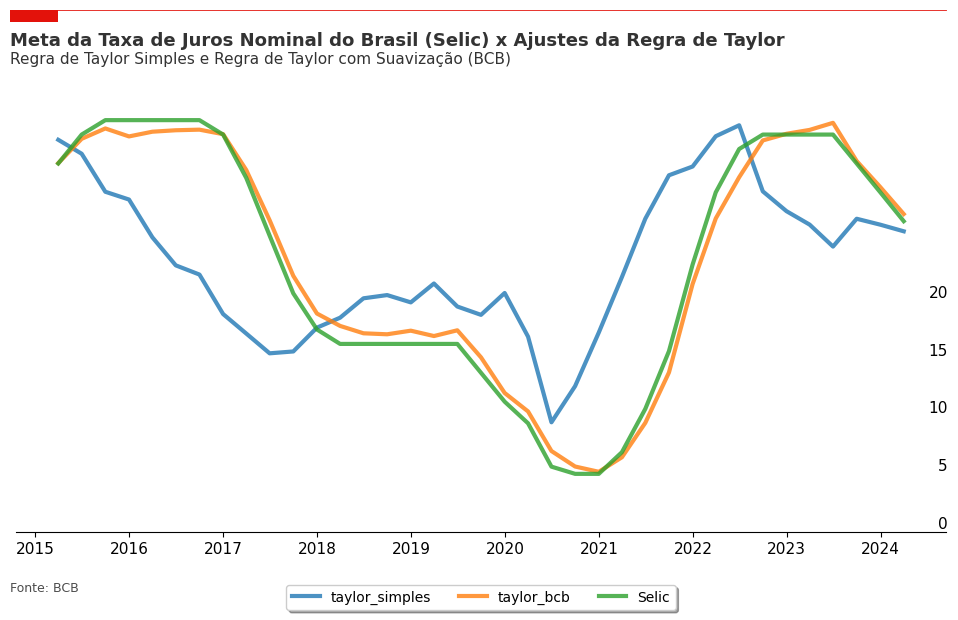

In [143]:
# Setup plot size.
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through country names and plot each one with a different color.
for i, variable in enumerate(variables):
    color = plt.cm.tab10(i)  # Use a different color for each variable
    ax.plot(results_long[results_long['variable'] == variable]['date_quarter'],
            results_long[results_long['variable'] == variable]['value'],
            color=color,
            alpha=0.8,
            linewidth=3,
            label=variable)  # Add label for legend

# Add legend below the plot.
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=len(variables))

######### Estética do Gráfico #########
# Remove splines. Can be done one at a time or can slice with a list.
ax.spines[['top', 'right', 'left']].set_visible(False)

# Shrink y-lim to make plot a bit tighter
ax.set_ylim(0, 16)

# Reformat x-axis tick labels
ax.xaxis.set_tick_params(labelsize=11)

# Reformat y-axis tick labels
ax.set_yticklabels(np.arange(0, 25, 5), ha='right', verticalalignment='bottom')

ax.yaxis.set_tick_params(pad=-2, labeltop=True, labelbottom=False, bottom=False, labelsize=11)

# Add in line and tag
ax.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#E3120B', linewidth=.6)
ax.add_patch(plt.Rectangle((0.12, .98), 0.04, -0.02, facecolor='#E3120B', transform=fig.transFigure, clip_on=False, linewidth=0))

# Add in title and subtitle
ax.text(x=0.12, y=.92, s="Meta da Taxa de Juros Nominal do Brasil (Selic) x Ajustes da Regra de Taylor", transform=fig.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)
ax.text(x=0.12, y=.89, s="Regra de Taylor Simples e Regra de Taylor com Suavização (BCB)", transform=fig.transFigure, ha='left', fontsize=11, alpha=.8)

# Set source text
ax.text(x=0.12, y=0.01, s="""Fonte: BCB""", transform=fig.transFigure, ha='left', fontsize=9, alpha=.7)

plt.show()